<h2 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Methodology: Model Architecture </centre></strong></h2>

#### 03.Model Development
**Objective:** Train a Tradicional RNN model on the preprocessed dataset.

**Model Training:** <br>
<br>
 - **Base Model:**
    + Defines the RNN architecture;
    + Compiles the model with the Adam optimizer and categorical cross-entropy loss;
    + Test adding mores layers to see if the performance gets better
 
 - **Training and Evaluation:**
    + Utilizes EarlyStopping and ModelCheckpoint callbacks for efficient training.
    + Trains the model and evaluates its performance on the validation set.
    + Includes code to visualize training and validation accuracy over epochs.

---

## **Carregamento das Bibliotecas Base**

In [ ]:
import os 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings('ignore')

## **Carregamento e Leitura do *Dataset* Pré-processado**

In [ ]:
# Definir o caminho do arquivo relativo ao diretório do script
#file_path = os.path.join(os.getcwd(), 'RNN_dataset', 'concatDataset.csv')

base_dir = r'C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets'
file_name = 'preprocessDataset.csv'

file_path = os.path.join(base_dir, file_name)
print(file_path)

C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets\preprocessDataset.csv


+ Utilização do método `read_csv()` para leitura do arquivo CSV com os dados pré-processados

In [ ]:
df_motionSense = pd.read_csv(file_path)

+ Visualização das 5 primeiras linhas do *dataset* utilizando o método `head()`

In [ ]:
df_motionSense.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,category_encoded
0,0.972412,1.112051,0.372160,2.329043,-0.814143,0.190001,0.163109,0.417746,0.891213,0.591696,-0.307112,0.677785,0
1,0.972325,1.157371,0.361670,2.365755,-0.865384,0.187932,0.443882,0.221714,0.524710,0.436217,-0.038492,0.186239,0
2,0.972184,1.184141,0.357830,2.387092,-0.896006,0.186328,-0.080028,-0.036082,0.274351,0.006391,0.082024,-0.342729,0
3,0.965350,1.190361,0.360527,2.390690,-0.903162,0.156397,-0.019555,-0.594680,0.017573,-0.032954,0.084569,0.148985,0
4,0.951164,1.192398,0.358982,2.388570,-0.905503,0.094676,0.054879,-0.519408,0.027154,0.395098,0.349372,-0.111607,0


## **Definição de Variáveis Fixas**

In [ ]:
NUM_FEATURES = df_motionSense.shape[1] - 1
NUM_CLASSES = df_motionSense['category_encoded'].nunique()
EPOCHS = 50

**Sequencing Data for Temporal Analysis**

We define a sequence generator function that creates sequences of input features and corresponding target labels from the training and testing data. These sequences have a window length of 150 with a stride of 10. The mode of target labels within each sequence is calculated to represent the label for that sequence. This prepares the data for temporal analysis tasks.

## **Preparação do *Dataset* para treino dos modelos de classificação de atividades baseado em RNN**

+ A função `prepare_data()` realiza o pré-processamento necessário para treinar um modelo de classificação de atividades baseado em RNNs. Este cria sequências de dados a partir da função `create_sequence()` e divide o conjunto de dados em treino e teste.

Esta divisão foi feita com base na função `train_test_split()` do scikit-learn que permite dividir o conjunto de dados em conjuntos de treino e teste. Este separa as *features* ('x_columns') e a *target* ('y_columns') com um tamanho de conjunto de teste de, neste caso, 20% (`test_size=0.2`), garantindo que os comprimentos dos conjuntos de treino para *features* e *targets* sejam os mesmos.

In [ ]:
def prepare_data(df, window_length):
    """
    Preprocesses the dataset for training an RNN-based activity classification model.

    Args:
        df (pandas.DataFrame): The input dataset containing features and labels.
        window_length (int): The desired length of the time window for creating sequences.

    Returns:
        X_train, X_test, y_train, y_test: Processed training and testing data.
    """
    def create_sequences(data, target, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i+window_size]
            label = target[i+window_size]
            sequences.append(seq)
            targets.append(label)
        return np.array(sequences), np.array(targets)
    
    y = df['category_encoded']
    X = df.drop(columns=['category_encoded'])
    
    X_seq, y_seq = create_sequences(X, y, window_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=y.nunique())
    y_test = to_categorical(y_test, num_classes=y.nunique())
    
    return X_train, X_test, y_train, y_test

## **Definição de métodos de Regularização**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## **Definição da função de Avaliação**

In [ ]:
def plot_training_results(history):
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

## **Definição de Arquiteturas**

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 1 </centre></strong></h2>

# multilayer

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,123 (121.57 KB)

 Trainable params: 31,103 (121.50 KB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.6862 - loss: 0.7180 - val_accuracy: 0.8724 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.8936 - loss: 0.3597 - val_accuracy: 0.9348 - val_loss: 0.2203 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9050 - loss: 0.3316 - val_accuracy: 0.9354 - val_loss: 0.2176 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - accuracy: 0.9095 - loss: 0.3164 - val_accuracy: 0.9232 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.9152 - loss: 0.3017 - val_accuracy: 0.9303 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.9066 - loss: 0.3226 - val_accuracy: 0.9125 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step -

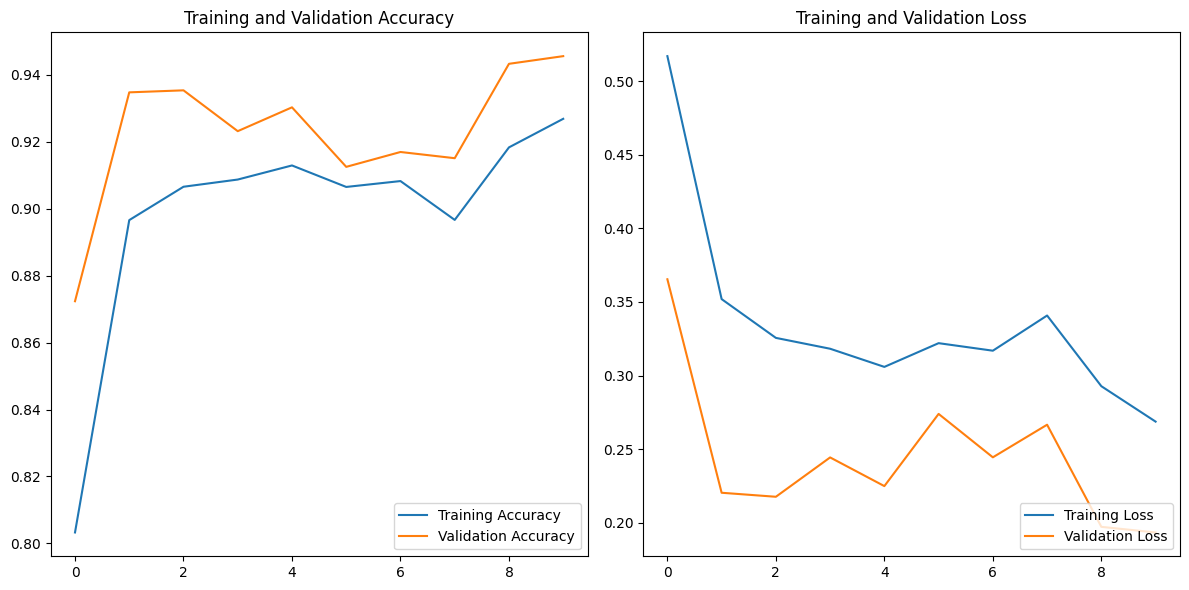

In [ ]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.save('../models/model/model_4_h5.h5')
model.save('../models/model/model_4_h5.keras')

start_time = time.time()

history_5 = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model/history_5.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_5.history, file)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_5)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 20, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603 (146.89 KB)

 Trainable params: 37,403 (146.11 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - accuracy: 0.6238 - loss: 0.8484 - val_accuracy: 0.6499 - val_loss: 0.7353 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.6434 - loss: 0.7011 - val_accuracy: 0.6738 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.6449 - loss: 0.6820 - val_accuracy: 0.6749 - val_loss: 0.7473 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 171s 16ms/step - accuracy: 0.6315 - loss: 0.7321 - val_accuracy: 0.6697 - val_loss: 0.5973 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.6472 - loss: 0.6775 - val_accuracy: 0.6775 - val_loss: 0.6029 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.6580 - loss: 0.6501 - val_accuracy: 0.6727 - val_loss: 0.5923 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/ste

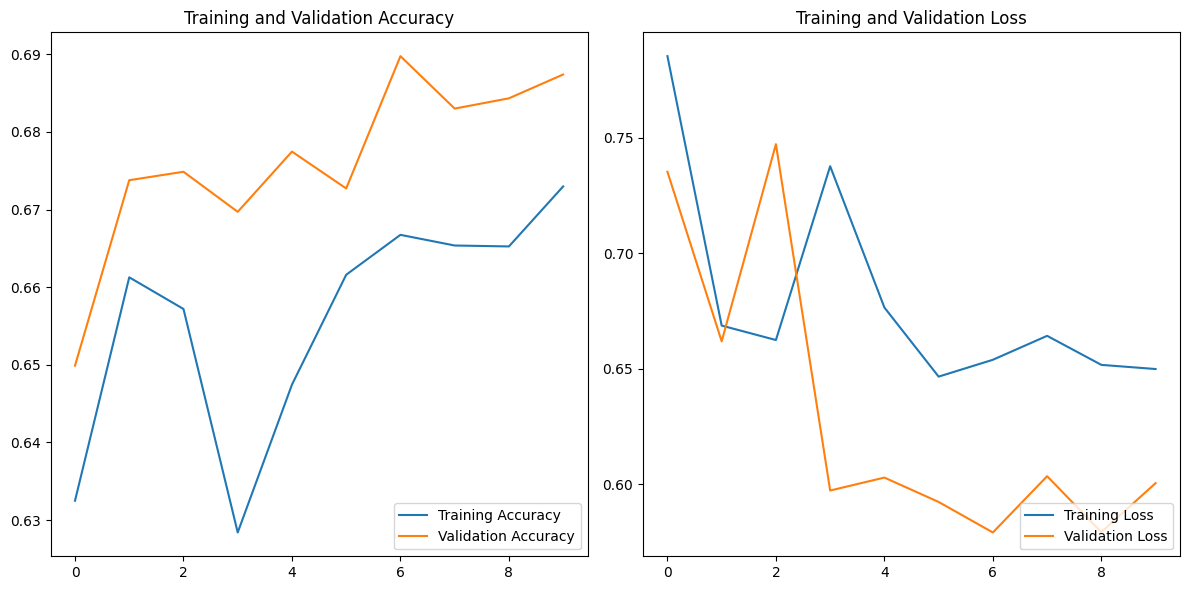

In [ ]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.save('../models/model/model_4_h5.h5')
model.save('../models/model/model_4_h5.keras')

start_time = time.time()

history_5 = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model/history_5.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_5.history, file)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_5)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_13 (SimpleRNN)       │ (None, 20, 64)         │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,515 (33.26 KB)

 Trainable params: 8,323 (32.51 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.8352 - loss: 0.4213 - val_accuracy: 0.9462 - val_loss: 0.1827 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.9342 - loss: 0.2251 - val_accuracy: 0.9480 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.9387 - loss: 0.2134 - val_accuracy: 0.9468 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9393 - loss: 0.2078 - val_accuracy: 0.9483 - val_loss: 0.1723 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9413 - loss: 0.2023 - val_accuracy: 0.9498 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9326 - loss: 0.2249 - val_accuracy: 0.9513 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step -

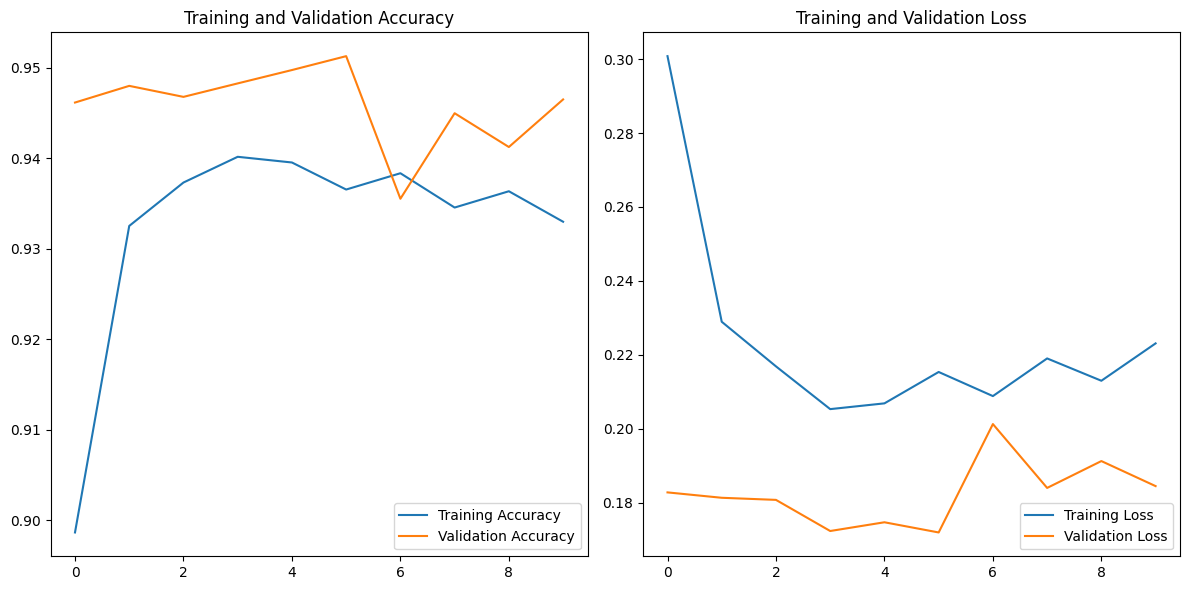

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization

WINDOW_LENGTH = 20

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    SimpleRNN(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Adicione uma camada RNN com 64 unidades e Dropout
#model.add(SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma segunda camada RNN com 32 unidades e Dropout
#model.add(SimpleRNN(32, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma camada densa para a saída com ativação softmax
#model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

#model_4.save('../models/model_4/model_4_h2.h5')
#model_4.save('../models/model_4/model_4_h2.keras')

#start_time = time.time()

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Tempo de execução: {execution_time} segundos")

#history_path = '../models/model_4/history_2.pkl'
#with open(history_path, 'wb') as file:
 #   pickle.dump(history_2.history, file)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_15 (SimpleRNN)       │ (None, 20, 100)        │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,503 (126.96 KB)

 Trainable params: 32,103 (125.40 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.8514 - loss: 0.4067 - val_accuracy: 0.9414 - val_loss: 0.1939 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 171s 16ms/step - accuracy: 0.9305 - loss: 0.2339 - val_accuracy: 0.9431 - val_loss: 0.1906 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.9360 - loss: 0.2153 - val_accuracy: 0.9462 - val_loss: 0.1816 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9396 - loss: 0.2049 - val_accuracy: 0.9453 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.9389 - loss: 0.2050 - val_accuracy: 0.9525 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.9405 - loss: 0.2003 - val_accuracy: 0.9539 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/st

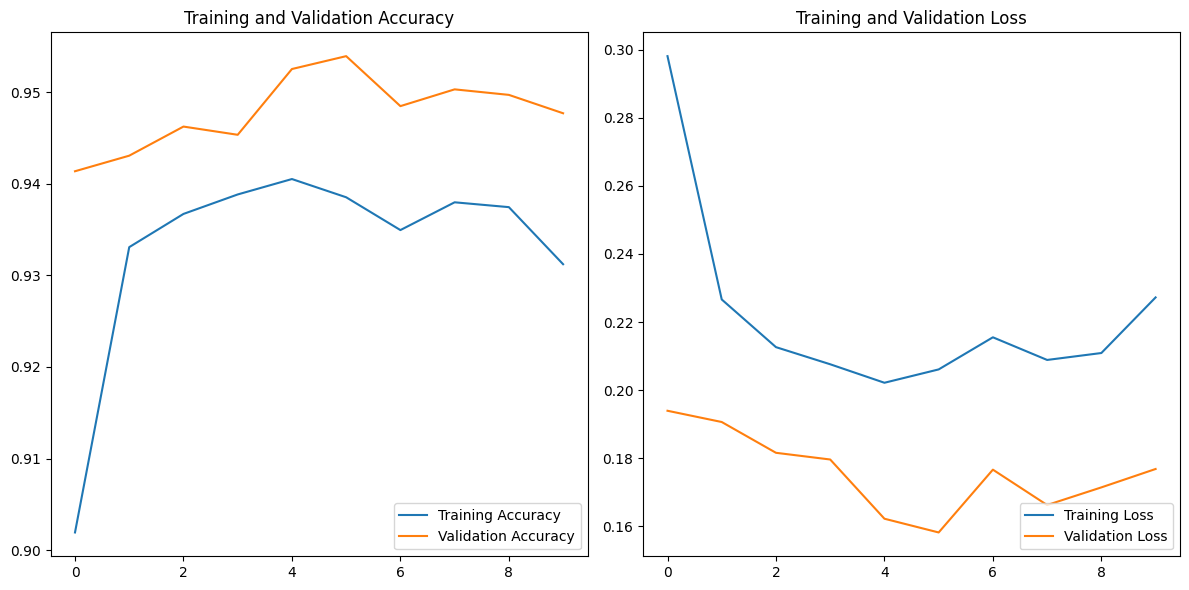

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization

WINDOW_LENGTH = 20

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model = Sequential([
    SimpleRNN(100, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    SimpleRNN(100, activation='tanh', return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Adicione uma camada RNN com 64 unidades e Dropout
#model.add(SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma segunda camada RNN com 32 unidades e Dropout
#model.add(SimpleRNN(32, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma camada densa para a saída com ativação softmax
#model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

#model_4.save('../models/model_4/model_4_h2.h5')
#model_4.save('../models/model_4/model_4_h2.keras')

#start_time = time.time()

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Tempo de execução: {execution_time} segundos")

#history_path = '../models/model_4/history_2.pkl'
#with open(history_path, 'wb') as file:
 #   pickle.dump(history_2.history, file)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_17 (SimpleRNN)       │ (None, 20, 100)        │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 20, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,503 (126.96 KB)

 Trainable params: 32,103 (125.40 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - accuracy: 0.8338 - loss: 0.4382 - val_accuracy: 0.9445 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.9356 - loss: 0.2210 - val_accuracy: 0.9526 - val_loss: 0.1631 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9424 - loss: 0.1978 - val_accuracy: 0.9531 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9459 - loss: 0.1852 - val_accuracy: 0.9550 - val_loss: 0.1485 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9489 - loss: 0.1759 - val_accuracy: 0.9560 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9431 - loss: 0.1902 - val_accuracy: 0.9528 - val_loss: 0.1472 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step -

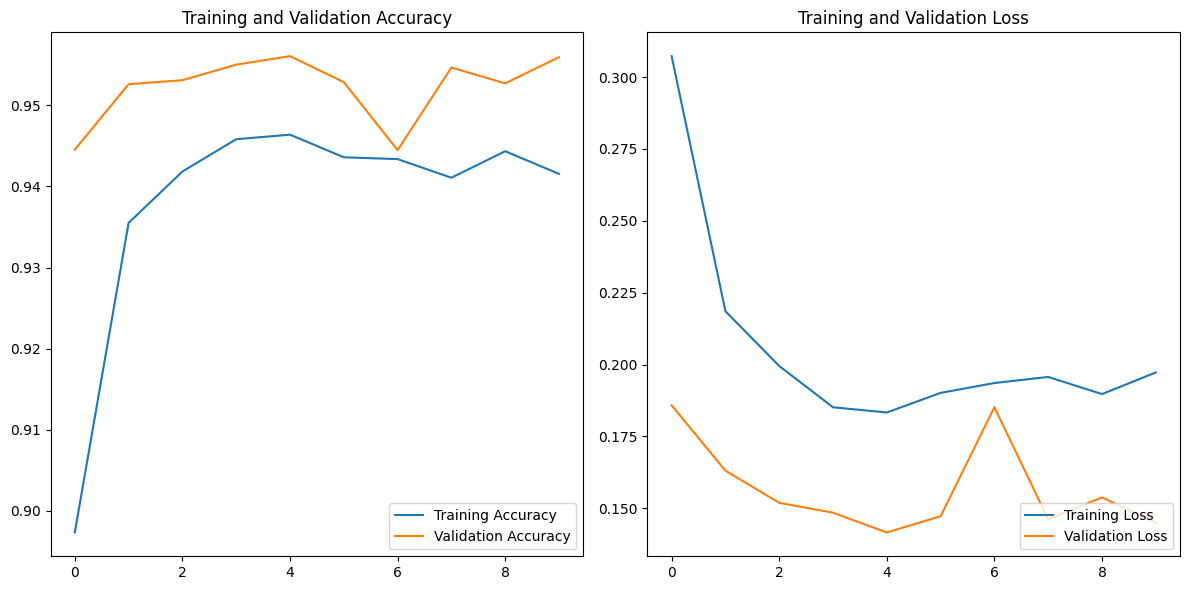

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization

WINDOW_LENGTH = 20

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model = Sequential([
    SimpleRNN(100, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    BatchNormalization(),
    SimpleRNN(100, activation='relu', return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Adicione uma camada RNN com 64 unidades e Dropout
#model.add(SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma segunda camada RNN com 32 unidades e Dropout
#model.add(SimpleRNN(32, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma camada densa para a saída com ativação softmax
#model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

#model_4.save('../models/model_4/model_4_h2.h5')
#model_4.save('../models/model_4/model_4_h2.keras')

#start_time = time.time()

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Tempo de execução: {execution_time} segundos")

#history_path = '../models/model_4/history_2.pkl'
#with open(history_path, 'wb') as file:
 #   pickle.dump(history_2.history, file)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history)

In [ ]:
model = Sequential()
# Adicione a primeira camada SimpleRNN com dropout
model.add(SimpleRNN(units=50, return_sequences=True, activation='tahn'))
model.add(Dropout(0.5))

# Adicione a segunda camada SimpleRNN com dropout
model.add(SimpleRNN(units=50))
model.add(Dropout(0.5))

# Adicione a camada densa para classificação
model.add(Dense(units=3, activation='softmax'))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 50)         │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353 (32.63 KB)

 Trainable params: 8,353 (32.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS_SIZE, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 135s 8ms/step - accuracy: 0.7883 - loss: 0.5516 - val_accuracy: 0.9167 - val_loss: 0.2726
Epoch 2/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 119s 8ms/step - accuracy: 0.9075 - loss: 0.3047 - val_accuracy: 0.9130 - val_loss: 0.2915
Epoch 3/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 189s 12ms/step - accuracy: 0.9153 - loss: 0.2839 - val_accuracy: 0.9319 - val_loss: 0.2295
Epoch 4/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 137s 9ms/step - accuracy: 0.9179 - loss: 0.2780 - val_accuracy: 0.9302 - val_loss: 0.2325
Epoch 5/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.9186 - loss: 0.2736 - val_accuracy: 0.9354 - val_loss: 0.2255
Epoch 6/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.9162 - loss: 0.2803 - val_accuracy: 0.9263 - val_loss: 0.2477
Epoch 7/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.9115 - loss: 0.2923 - val_accuracy: 0.8985 - val_loss: 0.3048
Epoch 8/10
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accu

3959/3959 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9217 - loss: 0.2613
Test loss: 0.259573370218277, Test accuracy: 0.9223488569259644


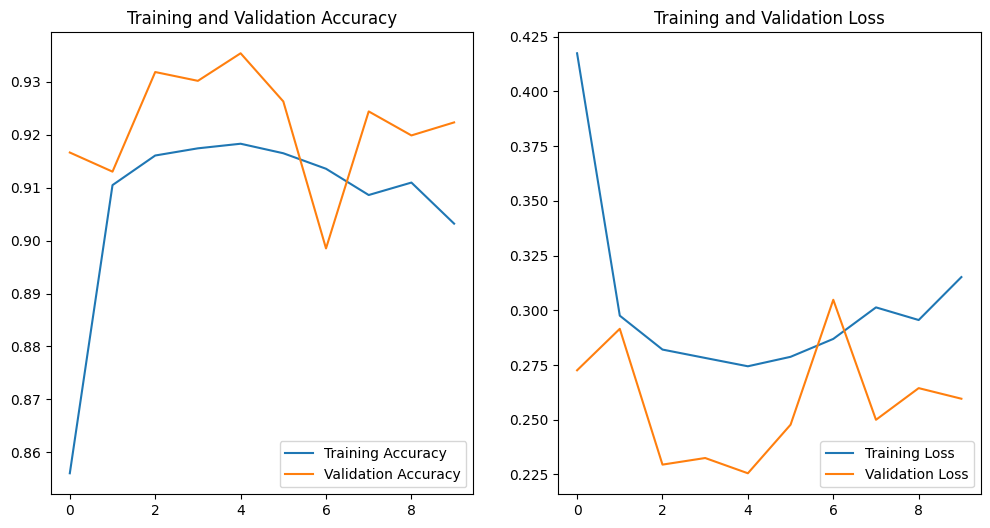

In [ ]:
# Evaluate the model
import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')
 
 
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
 
loss = history.history["loss"]
val_loss = history.history["val_loss"]
 
 
#EPOCHS=15
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS_SIZE),acc, label="Training Accuracy")
plt.plot(range(EPOCHS_SIZE),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
 
#plt.figure(figsize=(6,6))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS_SIZE),loss, label="Training Loss")
plt.plot(range(EPOCHS_SIZE),val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.9094 - loss: 0.3019 - val_accuracy: 0.9140 - val_loss: 0.2830
Epoch 2/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.8992 - loss: 0.3248 - val_accuracy: 0.9043 - val_loss: 0.3024
Epoch 3/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.9015 - loss: 0.3189 - val_accuracy: 0.9096 - val_loss: 0.2945
Epoch 4/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8992 - loss: 0.3258 - val_accuracy: 0.9154 - val_loss: 0.2775
Epoch 5/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8993 - loss: 0.3252 - val_accuracy: 0.8989 - val_loss: 0.3170
Epoch 6/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 102s 6ms/step - accuracy: 0.8899 - loss: 0.3484 - val_accuracy: 0.8930 - val_loss: 0.3327
Epoch 7/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8853 - loss: 0.3625 - val_accuracy: 0.9048 - val_loss: 0.3052
Epoch 8/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy

3959/3959 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6066 - loss: 0.9097
Test loss: 0.9107359647750854, Test accuracy: 0.605658233165741


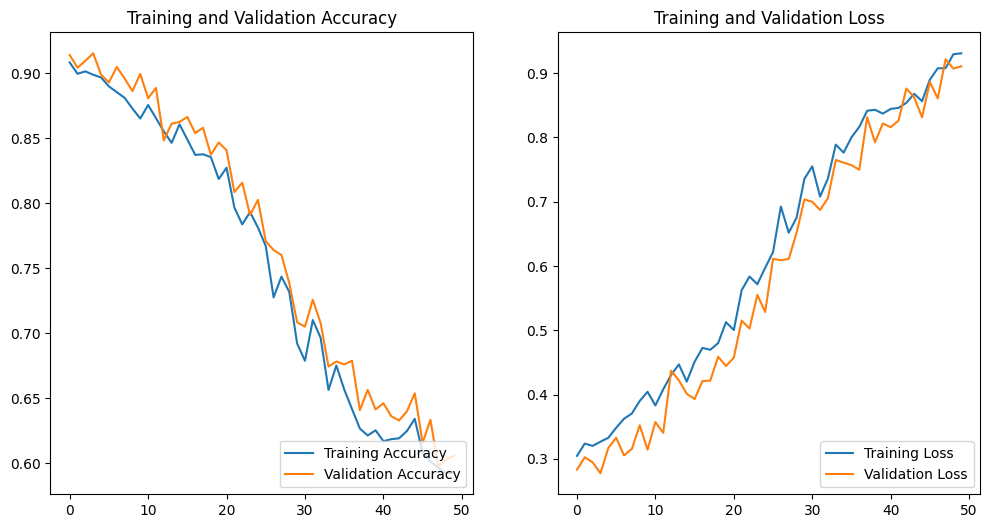

In [ ]:
# Evaluate the model
import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')
 
 
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
 
loss = history.history["loss"]
val_loss = history.history["val_loss"]
 
 
EPOCHS_SIZE=50
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS_SIZE),acc, label="Training Accuracy")
plt.plot(range(EPOCHS_SIZE),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
 
#plt.figure(figsize=(6,6))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS_SIZE),loss, label="Training Loss")
plt.plot(range(EPOCHS_SIZE),val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# Definição da arquitetura da rede neural
model = Sequential()

# Primeira camada RNN com ativação 'tanh'
model.add(SimpleRNN(50, input_shape=(50, X_train.shape[2]), activation='tanh', return_sequences=True))

# Dropout para regularização
model.add(Dropout(0.5))

# Segunda camada RNN com ativação 'tanh'
model.add(SimpleRNN(50, activation='tanh'))

# Dropout para regularização
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(y_train.shape[1], activation='softmax'))


# Compilação do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sumário do modelo
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50, 50)         │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,355 (32.64 KB)

 Trainable params: 8,355 (32.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS_SIZE, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.7775 - loss: 0.5718 - val_accuracy: 0.9219 - val_loss: 0.2588
Epoch 2/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.9073 - loss: 0.3090 - val_accuracy: 0.9312 - val_loss: 0.2405
Epoch 3/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.9166 - loss: 0.2824 - val_accuracy: 0.9362 - val_loss: 0.2200
Epoch 4/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 118s 7ms/step - accuracy: 0.9186 - loss: 0.2758 - val_accuracy: 0.9336 - val_loss: 0.2262
Epoch 5/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 132s 8ms/step - accuracy: 0.9183 - loss: 0.2750 - val_accuracy: 0.9288 - val_loss: 0.2351
Epoch 6/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.9185 - loss: 0.2751 - val_accuracy: 0.9188 - val_loss: 0.2687
Epoch 7/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.9157 - loss: 0.2811 - val_accuracy: 0.9173 - val_loss: 0.2669
Epoch 8/50
15836/15836 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - accurac